# Machine learning compilation of quantum circuits -- experiments
> Flexible and efficient learning with JAX+numpy
- toc: true 
- badges: true
- comments: true
- categories: [qiskit, JAX, machine learning, compilation]
- image: images/upsidedown.jpg

# Introduction

In [1]:
#collapse
import jax.numpy as jnp
import numpy as np

from jax import random, value_and_grad, ops, jit, lax, vmap, grad, partial
key = random.PRNGKey(42)

# !pip install tensornetwork
# !pip install optax
# !pip install qiskit
# !pip install pylatexenc

import tensornetwork as tn
tn.set_default_backend('jax')

import optax

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit import Parameter
from qiskit.transpiler.passes.synthesis import UnitarySynthesis
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_gate

from scipy.stats import unitary_group

import matplotlib.pyplot as plt
import re

from pandas import DataFrame

## Motivation
Ever since I read the paper by L.Madden and A.Simonetto ([original preprint](http://arxiv.org/abs/2106.05649), [my review](https://idnm.github.io/blog/machine%20learning/compilation/qiskit/paper%20review/2021/07/22/Machine-learning-compilation-of-quantum-circuits.html)) I knew I want to do this kind of experiments myself. At first I hoped that there is a well-established framework where I can easily build quantum circuits and then optimize them efficiently. However, [I was not able to find a good fit for my problem](https://quantumcomputing.stackexchange.com/questions/20718/software-tools-to-train-quantum-circuits-with-parameters) (I later found [quimb](https://quimb.readthedocs.io/en/latest/index.html) which [might do what I want](https://quimb.readthedocs.io/en/latest/examples/ex_tn_train_circuit.html), but in the end I'm glad I worked things out from scratch). In the end I went for `numpy`+`JAX` combination which while being quite low-level was not a big problem to get working. 

Here I will give a walk thorough this implementation and show experiments with compilation of random unitaries. However, in my opinion truly interesting stuff is concerned with the compilation of special gates, say multi-controlled Toffolis on restricted connectivity. I intend to look at this kind problems in detail in a future blog post, also see [this preprint](http://arxiv.org/abs/2109.13223) for advances in that direction.

> *NOTE*: While I was working on my own experiments another [preprint appeared](http://arxiv.org/abs/2109.06770), by P.Rakyta and Z.Zimborás, which is very similar to the work of M&S in terms of numerical results. Despite the striking similarities these works are independent. As a bonus R&Z also provide a numerical package [SQUANDER](https://zenodo.org/record/4508680#.YVw-uYBBxNi) that allows to play with their framework for compilation of unitaries. You might wish to check that out if you are interested in doing some experiments yourself.


## The problem
OK, so first a brief recap of what is the compilation problem. Given a quantum circuit we need to find an equivalent one, which satisfies certain requirements. A typical restrictions are to use only some specific two-qubits gates and to be compatible with limited connectivity. I gave a more detailed intro [here](https://idnm.github.io/blog/machine%20learning/compilation/qiskit/paper%20review/2021/07/22/Machine-learning-compilation-of-quantum-circuits.html). Here is a nearly-trivial example: a simple $CNOT$ gate 

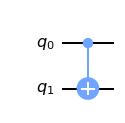

In [2]:
#collapse
qc = QuantumCircuit(2)
qc.cx(0, 1)
qc.draw(output='mpl')

can be decomposed in terms of the entangling $CZ$ gate and single-qubit gates $rx, ry, rz$ as follows

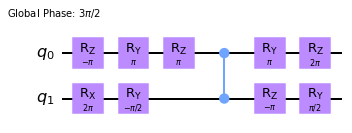

In [3]:
#collapse
qc_compiled = transpile(qc, basis_gates=['cz', 'rx', 'ry', 'rz'], optimization_level=3)
qc_compiled.draw(output='mpl')

Now, for generic $n$-qubit unitaries one needs exponentially many entangling gates for the compilation. More precisely, there is a [theoretical lower bound](https://dl.acm.org/doi/10.5555/968879.969163) $\#CNOTs\ge \frac14 \left(4^n-3n-1\right)$ on the amount of $CNOT$s required for compilation of any $n-$qubit unitary outside a measure zero set. Crucially, this measure zero set might in fact be of principal interest to quantum computing as it includes many operators featuring in most algorithms (such as multi-controlled gates). In this post I will only adress compilation of random unitaries and discuss compilation of special cases in a future post. For later reference here is the function returning a theoretical lower bound

In [4]:
def TLB(n):
    return int((4**n-3*n-1)/4 + 1)

for n in range(1, 7):
    print('TLB for {}-qubit unitary is {}'.format(n, TLB(n)))

TLB for 1-qubit unitary is 1
TLB for 2-qubit unitary is 3
TLB for 3-qubit unitary is 14
TLB for 4-qubit unitary is 61
TLB for 5-qubit unitary is 253
TLB for 6-qubit unitary is 1020


Now, there is an algorithm called [quantum Shannon decomposition](https://arxiv.org/abs/quant-ph/0406176) to decompose an arbitary $n$-qubit unitary into a sequence of $CNOT$s and single-qubit rotations which requires roughly twice as many $CNOT$s as the theoretical lower bound implies. 

## 3-qubit example
As papers [M&S](http://arxiv.org/abs/2106.05649) and [R&Z](http://arxiv.org/abs/2109.06770) show, one can do better and eliminate the 2x overhead, at least numerically. Namely, it seems that precisely at the theoretical lower bound the exact or nearly-exact compilation is possible. Here is a real-life example. Consider the following 3-qubit circuit with $TLB(3)=14$ $CNOT$ gates

<img src="myimages/3qubitsequ.png" alt="Drawing" style="width: 800px;"/>

The claim is that with the appropriate choice of angles in rotation gates it can morhp into *any* 3-qubit unitary. To find the corresponding angles it is sufficient to run a numerical optimization minimizing the fidelity between this circuit's unitary and the target unitary. This is rather imressive, but calls for many questions. Why choose $CNOT$ gates? Why place them in that exact order? It appears to be an experical fact that precise location of entangling gates as well as their choice ($CNOT$, $CZ$, etc) makes little difference. Moreover, even restricted connectivity does not seem to force an overhead for compilation. I will back up these claims with numerical experiments.

## Contents
The rest of this post is divided into two parts. In the first I write some `numpy`/`JAX`/`qiskit` code that allows to construct and efficiently optimize circuits of interest. I try to give some explanations of the underlying numerical framework, but please do not mistake me for a real expert on the topic. Still, the resulting performance seems to be good enough to reproduce results of the existing preprints. This part can safely be skipped if you are only interested in the results.

In the second part of the post I will do a number of experiments compiling random unitaries with varying numbers of qubits, different types of entangling gates, restricted connectivity and try to draw some general lessons from them. 
> *NOTE*: This blog post is also a fully-functional jupyter notebook. You can open it in colab or download it and perform more experiments yourself!

# Numerical framework

## Building blocks for quantum circuits

First let us define the basic 1- and 2-qubit gates in matrix form. For now you can safely ignore the use `jnp` arrays instead of `np` arrays.

In [5]:
# Matrix represntations of CNOT, CZ and single-qubit rotations

# Controlled-NOT (or controlled-X gate)
cx_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]])

# Controlled-Z gate
cz_mat = jnp.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, -1]])

# Pauli matrices
x_mat = jnp.array([[0, 1],
                   [1, 0]])

y_mat = jnp.array([[0, -1j],
                   [1j, 0]], dtype=jnp.complex64)

z_mat = jnp.array([[1, 0],
                   [0, -1]])

# Rotation gates
def rx_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*x_mat*jnp.sin(a/2)

def ry_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*y_mat*jnp.sin(a/2)

def rz_mat(a):
    return jnp.cos(a/2)*jnp.identity(2)-1j*z_mat*jnp.sin(a/2)

The circuits that we are going to train will be built out of two types of 2-qubit blocks. Here are the definitions:

In [6]:
# Class for a single building block
class block():
    def __init__(self, gate_name, angles):
        self.gate_name = gate_name
        self.angles = angles
    
    # Quantum circuit in `qiskit` corresponding to our block
    def circuit(self):
        qc = QuantumCircuit(2)
        if self.gate_name == 'cx':
            qc.cx(0, 1)
        elif self.gate_name == 'cz':
            qc.cz(0, 1)
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        angles = np.array(self.angles) # convert from JAX array to numpy array if applicable.
        
        qc.ry(angles[0], 0)
        qc.rx(angles[1], 0)
        qc.ry(angles[2], 1)
        qc.rx(angles[3], 1)
        
        return qc
    
    # JAX-compatible unitary corresponding to our block
    def unitary(self):
        if self.gate_name == 'cx':
            entangling_matrix = cx_mat
        elif self.gate_name == 'cz':
            entangling_matrix = cz_mat
        else:
            print("Gate '{}' not yet supported'".format(self.gate_name))
        
        x_rotations = jnp.kron(rx_mat(self.angles[1]), rx_mat(self.angles[3]))
        y_rotations = jnp.kron(ry_mat(self.angles[0]), ry_mat(self.angles[2]))
        
        return x_rotations @ y_rotations @ entangling_matrix

Here is how they look:
`cz` block

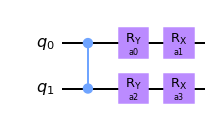

In [7]:
a0, a1, a2, a3 = [Parameter(a) for a in ['a0', 'a1', 'a2', 'a3']]
block('cz', [a0, a1, a2, a3]).circuit().draw(output='mpl')

and `cx` block

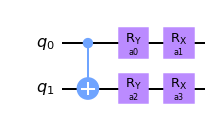

In [8]:
block('cx', [a0, a1, a2, a3]).circuit().draw(output='mpl')

Our `block` class can return a `qiskit` circuit and the correponding unitary matrix. Of course we could have extracted the unitary from the circuit itself via `qiskit` API, but this would make the matrix representation incompatible with `JAX` which will be our workhorse for optimization. So at this point we needed a bit of wheel reivention. Let's check that our implementation is consistent with `qiskit`:

In [9]:
# That's how you use random numbers with JAX. Don't worry if this is not familiar.
key, subkey = random.split(key) 
angles = random.uniform(key, shape=(4,), minval=0, maxval=2*jnp.pi)

for gate in ['cx', 'cz']:
    b = block(gate, angles)
    qc = b.circuit()
    qs_unitary = Operator(qc.reverse_bits()).data # Yes, we need to reverse bits in qiskit to match our conventions.
    our_unitary = b.unitary()
    print('qiskit unitary is the same as our unitary for block with gate {}: {}'.format(gate, jnp.allclose(qs_unitary, our_unitary)))

qiskit unitary is the same as our unitary for block with gate cx: True
qiskit unitary is the same as our unitary for block with gate cz: True


To match matrix representations of quantum circuits might be a headache as I discussed in [another post](https://idnm.github.io/blog/qiskit/tensor%20networks/quantum%20concepts/2021/08/18/Matrix-representation-of-quantum-circuits.html), so this was a neseccary check to do.

Our two bulding blocks (`cz` and `cx`) only differ by the type of the two-qubit gate. The circuits that we are going to build seem to do equally well for any choice of two-qubit gate. I will mostly use `cz` gate because it is symmetric under the swap of qubits, but I will also occasinally bring up the `cx` gate to illustrate that it has the same performance. Angles $a_0$-$a_3$ are going to be optimized.

## Optimization with `JAX`

### A word about `JAX`

What is `JAX`? Well, I think of it as `numpy` on steroids. You can check out [the official documentation](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) or numerous nice overwievs on the web. For our purposes two key features of `JAX` are
1. Autograd  
2. JIT or just-in-time compilation

Autograd allows to define functions the same you do in `numpy` and have analytic derivatives computed for you. At the moment `grad` function can only be applied to real scalars. For example, let us define the absolute value of the trace of `cx` block as function of rotation's gate angles

In [10]:
def block_tr_abs(angles):
    b = block('cx', angles)
    tr = jnp.trace(b.unitary())
    return jnp.abs(tr)

Since everything so far has been defined using `jax.numpy` we have immediate access to the gradient of this function

In [11]:
grad(block_tr_abs)([0.,1.,2.,3.])

[DeviceArray(0.03655498, dtype=float32),
 DeviceArray(-0.25903472, dtype=float32),
 DeviceArray(-0.7384602, dtype=float32),
 DeviceArray(-7.450581e-09, dtype=float32)]

Autograd feature of `JAX` allows us to just define the loss function associated with our circuit in plain `numpy` terms and use advanced first-order optimizers such as Adam out of the box.

`jit`-compilation when used with a bit of care, allows to speed up evaluation of similar expression by orders of magnitude. For example let us compare runtimes of the jitted and unjitted versions of our trace function. Let's first define a sample of random 
angles

In [12]:
test_angles = random.uniform(random.PRNGKey(0), shape=(1000, 4), minval=0, maxval=2*jnp.pi)

and time evaluation of unjitted trace function

In [13]:
%%time
for angles in test_angles:
    block_tr_abs(angles)

CPU times: user 13.2 s, sys: 1.07 s, total: 14.3 s
Wall time: 12 s


Now awe to the power of `jit`!

In [14]:
%%time
jit_block_tr_abs = jit(block_tr_abs)
for angles in test_angles:
    jit_block_tr_abs(angles)

CPU times: user 142 ms, sys: 8.66 ms, total: 151 ms
Wall time: 134 ms


What happend here is that during the first call to the `jit`ted function it's efficient compiled XLA version was constructed and then used to evaluate all subsequent calls. 

### Gradient descent

We will use the following measure of discrepance between two unitaries $disc(U, V) = 1-\frac1{N}\operatorname{Tr}\left( U^\dagger V\right)$ where $U,V$ are $N\times N$ matices. It is normalized so that $disc(U,U)=0$. Note that this measure is insensitive to global phases.

In [15]:
def disc(U, U_target):
    n = U_target.shape[0]
    return 1-jnp.abs((U.conj() * U_target).sum())/n

Here is the optimization routine that we are 
going to use. It is pretty straightforward and I will not give much explanations, but illustrate with an example.

In [16]:
@partial(jit, static_argnums=(0, 1, )) # <--- Here is where the magic happens! Remove this line and everything will run 1000 times slower:)
def unitary_update(loss_and_grad, opt, opt_state, angles):
    """Single update step."""
    loss, grads = loss_and_grad(angles)
    updates, opt_state = opt.update(grads, opt_state)
    angles = optax.apply_updates(angles, updates)
    return angles, opt_state, loss

def unitary_learn(U_func, U_target, n_angles, 
                  init_angles=None, key=random.PRNGKey(0),
                  learning_rate = 0.01, num_iterations=5000, 
                  target_disc = 1e-10):
    """Use Adam optimizer to minimize discrepancy between unitary U_func depending on n_angles and U_target. 
    Stop optimization when either max number of iterations is reached if the target discrepancy is achieved. """
    
    # If initial angles are not provided generate them at random.
    if init_angles is None:
        key = random.PRNGKey(0)
        angles = random.uniform(key, shape=(n_angles,), minval=0, maxval=2*jnp.pi)
    else:
        angles = init_angles
    
    # Loss function to minimize is dicrepancy defined above.
    loss_func = lambda angles: disc(U_func(angles), U_target)
    loss_and_grad = value_and_grad(loss_func)

    # Optimizer is taken from the `optax` library and its use is self-explanotory.
    opt = optax.adam(learning_rate)
    opt_state = opt.init(angles)
    
    # Optimization cycle
    angles_history=[]
    loss_history=[]
    for _ in range(num_iterations):
        angles, opt_state, loss = unitary_update(loss_and_grad, opt, opt_state, angles)
        angles_history.append(angles)
        loss_history.append(loss)
        if loss < target_disc:
            break
    
    return angles_history, loss_history

OK, now a very simple example. Say we want to find a $ZXZ$ decomposition of  $Y$-gate. Define:

In [17]:
def zxz_ansatz(angles):
    return rz_mat(angles[0]) @ rx_mat(angles[1]) @ rz_mat(angles[2])

Learning is now very simple: we give `unitary_learn` the ansatz unitary as function of angles, the target unitary and also explicitly the number of parameters to be trained:

In [18]:
angles_history, loss_history = unitary_learn(zxz_ansatz, y_mat, 3)

We can visualize the learning progress as follows:

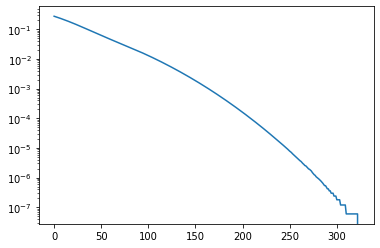

In [19]:
plt.plot(loss_history)
plt.yscale('log')

The learned angles in $ZXZ$ decomposition are

In [20]:
angles_history[-1]

DeviceArray([6.59216  , 3.1411407, 3.4505684], dtype=float32)

And it is not difficult to check directly that the result is equal to the $Y$ matrix up to a global phase with reasonable accuracy, indeed

In [21]:
jnp.around(1j*zxz_ansatz(angles_history[-1]), 3)

DeviceArray([[0.+0.j, 0.-1.j],
             [0.+1.j, 0.+0.j]], dtype=complex64)

## Quantum circuits with numpy

OK, now comes the tedious part. We need a simple and efficient way to assemble 1- and 2-qubit gates into quantum circuits in pure `numpy`. This requires some careful juggling of tensor indices and should probably deserve a separate discussion. But just to make sure that nobody reads this post to the I dump everything right here.

First, we'll think of a quantum circuit with $n-$qubits as $[2,2,\dots,2]=[2]^n$ tensor. 

Explanations and pictures here!

We need to implement several procedures to construct unitaries of the quantum circuits.

In [22]:
def transposition(n, placement):
    w = len(placement)
    t = list(range(w, n))

    for i, p in enumerate(placement):
        t.insert(p, i)

    return t

def apply_gate_to_tensor(gate, tensor, placement):
    gate_width = int(len(gate.shape)/2)
    tensor_width = int(len(tensor.shape)/2)
    gate_contraction_axes = list(range(gate_width, 2*gate_width))

    contraction = jnp.tensordot(gate, tensor, axes=[gate_contraction_axes, placement])
    t = transposition(tensor_width, placement) + list(range(tensor_width, 2*tensor_width)) # last indices are intact

    return jnp.transpose(contraction, axes=t)


def split_angles(angles, num_qubits, layer_len, num_layers, free_placements_len):
    
    surface_angles = angles[:3*num_qubits].reshape(num_qubits, 3)
    block_angles = angles[3*num_qubits:].reshape(-1, 4)
    layers_angles = block_angles[:layer_len*num_layers].reshape(num_layers, layer_len, 4)
    free_block_angles = block_angles[layer_len*num_layers:]
    
    return surface_angles, block_angles, layers_angles, free_block_angles

def build_unitary(num_qubits, block_type, angles, layer_placements=[[], 0], free_placements=[]):
    
    layer, num_layers = layer_placements
    
    layer_depth = len(layer)    
    num_blocks = len(layer)*num_layers+len(free_placements)
    
    surface_angles, _ , layers_angles, free_block_angles = split_angles(angles, num_qubits, len(layer), num_layers, len(free_placements))
    
#     print('u angles are {}'.format(angles))
#     print('u surface angles are {}'.format(surface_angles))
#     print('u layers angles are {}'.format(layers_angles))
#     print('u free block angles are {}'.format(free_blocks_angles))

    u = jnp.identity(2**num_qubits).reshape([2]*num_qubits*2)

    # Initial round of single-qubit gates
    for i, a in enumerate(surface_angles):
        gate = rz_mat(a[2]) @ rx_mat(a[1]) @ rz_mat(a[0])
        u = apply_gate_to_tensor(gate, u, [i])
    
    # Sequence of layers wrapped in fori_loop.
    layers_angles = layers_angles.reshape(num_layers, layer_depth, 4)

    def apply_layer(i, u, layer, layers_angles):
        angles = layers_angles[i]
    
        for a, p in zip(angles, layer):
            gate = block(block_type, a).unitary().reshape(2,2,2,2)
            u = apply_gate_to_tensor(gate, u, p)
            
        return u

    if num_layers>0:
        u = lax.fori_loop(0, num_layers, lambda i, u: apply_layer(i, u, layer, layers_angles), u)
    
    # Add remainder(free) blocks.
    for a, p in zip(free_block_angles, free_placements):
        gate = block(block_type, a).unitary().reshape(2,2,2,2)
        u = apply_gate_to_tensor(gate, u, p)

    return u.reshape(2**num_qubits, 2**num_qubits)


## Packing everything together: ansatz circuits

Now that we have defined our building blocks and convinience functions to assemble them together it is time to pack everything together and reap the harvest.

I will define `ansatz` class that assembles our building blocks according to a predefined pattern. It's `circuit` method gives a `qiskit` circuit which can be used for visualization and cross-checks. It's `unitary` attribute returns fully `jax`-compatible matri representation of the same circuit. Finally, its `learn` method uses our optimization routine to approximate atarget unitary. First the code, then an example.

In [27]:
class ansatz():
    
    def __init__(self, num_qubits, block_type, layer_placements=[[], 0], free_placements=[]):
        
        self.num_qubits = num_qubits
        self.block_type = block_type
        
        self.layer, self.num_layers = layer_placements
        self.free_placements = free_placements
        self.all_placements = self.layer*self.num_layers+free_placements
        
        self.num_angles = 3*num_qubits+4*len(self.all_placements)
        
        self.unitary = lambda angles: build_unitary(self.num_qubits, self.block_type, angles, 
                                                     [self.layer, self.num_layers], self.free_placements)
    def circuit(self, angles=None): 
        """qiskit circuit. If no angles given construct a parametric circuit."""
        
        if angles is None:
            angles = np.array([Parameter('a{}'.format(i)) for i in range(self.num_angles)])
            
        surface_angles, block_angles, _, _ = split_angles(angles, self.num_qubits, 
                                                          len(self.layer), self.num_layers, 
                                                          len(self.free_placements))        
        
        qc = QuantumCircuit(self.num_qubits)
        
        # Initial rounf of single-qubit gates
        for n, a in enumerate(surface_angles):
            qc.rz(a[0], n)
            qc.rx(a[1], n)
            qc.rz(a[2], n)
        
        # Entangling gates accoring to placements
        for a, p in zip(block_angles, self.all_placements):
            qc_block = block(self.block_type, a).circuit() 
            qc = qc.compose(qc_block, p)
            
        return qc
        
    def learn(self, u_target, **kwargs): 
        """Use numerical optimization to approximate u_target."""
        u_func = self.unitary
        return unitary_learn(u_func, u_target, self.num_angles, **kwargs)

Here is an example that should illustrate how all this can be used.

In [35]:
n_qubits = 3
block_type = 'cx'
# For technical reasons all entangling gates are divided into 'layers' and 'free' gates. 
single_layer = [[0, 1], [2, 1]] # We make single layer consisting of 'cx' block on qubits [0,1]
                                # followed by reversed 'cx' block on qubits [1,2]
layer_placements = [single_layer, 3] # The layer is repeated 3 times
free_placements = [[1, 0], [0, 1], [1, 2], [2, 1]] # After layers are placed remaining `free placements` are appended.

anz = ansatz(n_qubits, block_type, layer_placements=layer_placements, free_placements=free_placements)

Here is what resulting circuit looks like.

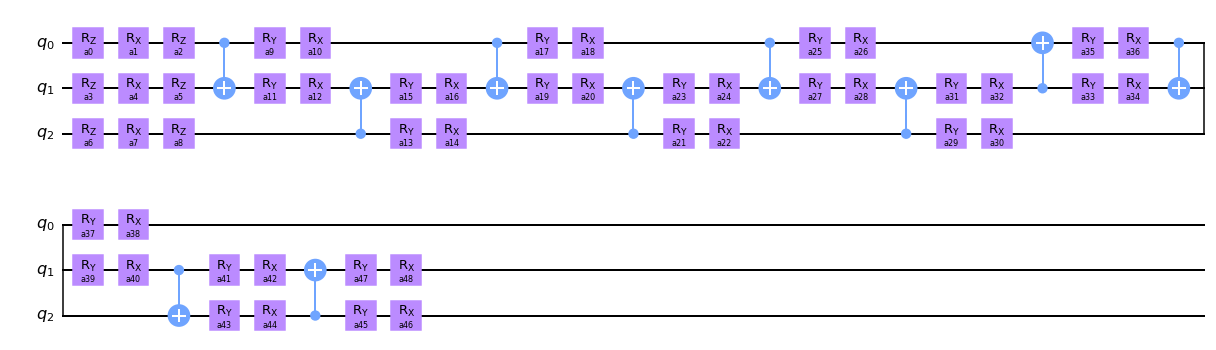

In [36]:
anz.circuit().draw(output='mpl')

Just to make sure let us check that the unitary matrix of this circuit extracted from qiskit agrees with our own implementation for a random set of angles.

In [43]:
angles = random.uniform(random.PRNGKey(0), shape=(anz.num_angles,), minval=0,maxval=2*jnp.pi)
qs_u = Operator(anz.circuit(angles).reverse_bits()).data # qiskit matrix representation
our_u = anz.unitary(angles) # our matrix representation
print(jnp.allclose(qs_u, our_u, atol=1e-2, rtol=1e-2))
ffuck

False


NameError: name 'ffuck' is not defined

## Layers

In [23]:
def sequ_layer(num_qubits):
    return [[i,j] for i in range(num_qubits) for j in range(i+1, num_qubits)]

def fill_layers(layer, depth):
    num_complete_layers = depth // len(layer)
    complete_layers = [layer, num_complete_layers]
    incomplete_layer = layer[:depth % len(layer)]
    
    return complete_layers, incomplete_layer

# Experiments

## Learning 2-qubit random unitary

Here is how we can learn a random two-qubit unitary. The ansatz is circuit is this:

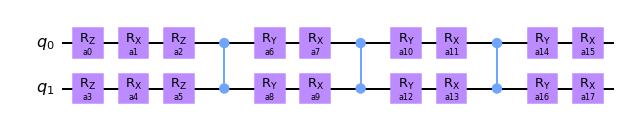

In [24]:
u_target = unitary_group.rvs(4, random_state=0)
ans = ansatz(2, 'cz', free_placements=[[0,1], [0,1], [0, 1]])
ans.circuit().draw(output='mpl')

Invoking the learning process is easy as pie:

CPU times: user 2.56 s, sys: 34.1 ms, total: 2.59 s
Wall time: 2.54 s


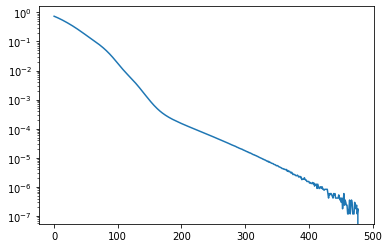

In [25]:
%%time

angles_history, loss_history = ans.learn(u_target)
plt.plot(loss_history)
plt.yscale('log')

The graph shows that we achive great fidelity in under 500 iterations. Just be be absolutely sure let us double-check using `qiskit`:

In [26]:
angles = angles_history[-1]
qc = ans.circuit(angles)
u_qs = Operator(qc.reverse_bits()).data
disc(u_qs, u_target)

DeviceArray(2.3841858e-07, dtype=float32)

You can try various experiments here: changing gate type from `cz` to `cx` (shoud not affect the result), decreasing the number of layers (fidelity won't be nearly as good) etc.

## Learning 3-qubit random unitary

OK, here instead of working at the theoretical lower bound let us make a sweep to see how fidelity increases (error drops) with the number of layers.

In [125]:
%%time

n_q = 3
u_target = unitary_group.rvs(2**n_q, random_state=0)

best_loss = [[], []]
for depth in range(4): # TLB(3)=14
    layer_placemets, free_placements = fill_layers(sequ_layer(n_q), depth)
    for i, gate in enumerate(['cx', 'cz']):
        ans = ansatz(n_q, gate, layer_placements=layer_placemets, free_placements=free_placements)
        angles, loss_history = ans.learn(u_target, target_disc=10e-4)
        best_loss[i].append(min(loss_history))

plt.plot(best_loss[0], label='cx loss')
plt.plot(best_loss[1], label='cz loss')
plt.legend()

CPU times: user 43.5 s, sys: 1.75 s, total: 45.3 s
Wall time: 40.1 s


The lesson here is that both types of two-qubits gate perform similarly well at all depths. I have not done experimenting with other gates, but I expect that this is very generic, i.e. it does not really matter what kind of gate to use at least as far as random unitaries are concerned.

## Learning 6-qubit random unitary

I do know that 3 is followed by 4, but shall we perhaps get more ambitious? Let's try to compile a 6-qubit random unitary (you can change $n_q=6$ to whatever you like):

CPU times: user 10min 39s, sys: 1min 24s, total: 12min 4s
Wall time: 11min 54s


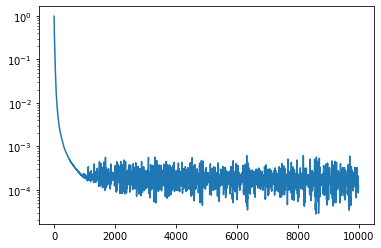

In [135]:
%%time

n_q = 6
depth = TLB(n_q)
layer_placements, free_placements = fill_layers(sequ_layer(n_q), depth)

u_target = unitary_group.rvs(2**n_q, random_state=0)
ans = ansatz(n_q, 'cz', layer_placements=layer_placements, free_placements=free_placements)

angles_history, loss_history = ans.learn(u_target, num_iterations=10000)

plt.plot(loss_history)
plt.yscale('log')

Note that depth of the theoretical lower bound for 6 qubits is $TLB(6)=1020$ which implies that there are $\approx 4000$ parameters in our ansatz. On my modest laptop the training completes in under 3 minutes. I would not claim this to be the cutting edge, but our `JAX` setup seems to be no worse than results from the published papers.

In [138]:
qc = QuantumCircuit(3)
qc.ccx(0,1,2)
u_toff3 = Operator(qc.reverse_bits()).data

CPU times: user 9.12 s, sys: 234 ms, total: 9.35 s
Wall time: 8.58 s


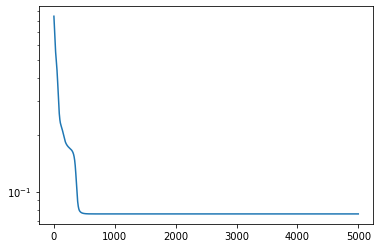

In [147]:
%%time

layer_placements, free_placements = fill_layers(sequ_layer(3), 7)
ans = ansatz(3, 'cx', layer_placements=layer_placements, free_placements=free_placements)
ans.circuit().draw(output='mpl')

u = ans.unitary



angles_history, loss_history = ans.learn(u_toff3)
plt.plot(loss_history)
plt.yscale('log')

## Restricted topology